In [3]:
df<-read.csv('d:/data/soccer/player.csv')
head(df)

id,player_name,birthday,preferred_foot,age,height,weight,potential,right_foot,left_foot,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,overall_rating,Label
1,Aaron Appindangoye,1992-02-29,right,27,183,187,71,1,0,...,65,69,69,6,11,10,8,8,67,0
2,Aaron Cresswell,1989-12-15,right,30,170,146,71,1,0,...,65,69,69,6,11,10,8,8,67,0
3,Aaron Doran,1991-05-13,right,28,170,163,66,1,0,...,65,66,69,6,11,10,8,8,62,0
4,Aaron Galindo,1982-05-08,right,37,183,198,65,1,0,...,62,63,66,5,10,9,7,7,61,0
5,Aaron Hughes,1979-11-08,right,40,183,154,65,1,0,...,62,63,66,5,10,9,7,7,61,0
6,Aaron Hunt,1986-09-04,left,33,183,161,76,0,1,...,76,75,78,14,7,9,9,12,74,1


In [4]:
library(dplyr)
#분석에 사용하지 않을 필드 제외
df<-df %>% select(-id,-player_name,-birthday,-preferred_foot,
                 -overall_rating)
dim(df)
head(df)

Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



[1] 10935    40

age,height,weight,potential,right_foot,left_foot,crossing,finishing,heading_accuracy,short_passing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,Label
27,183,187,71,1,0,49,44,71,61,...,48,65,69,69,6,11,10,8,8,0
30,170,146,71,1,0,49,44,71,61,...,48,65,69,69,6,11,10,8,8,0
28,170,163,66,1,0,49,44,71,61,...,48,65,66,69,6,11,10,8,8,0
37,183,198,65,1,0,48,43,70,60,...,47,62,63,66,5,10,9,7,7,0
40,183,154,65,1,0,48,43,70,60,...,47,62,63,66,5,10,9,7,7,0
33,183,161,76,0,1,80,53,58,71,...,59,76,75,78,14,7,9,9,12,1



   0    1 
5230 5705 

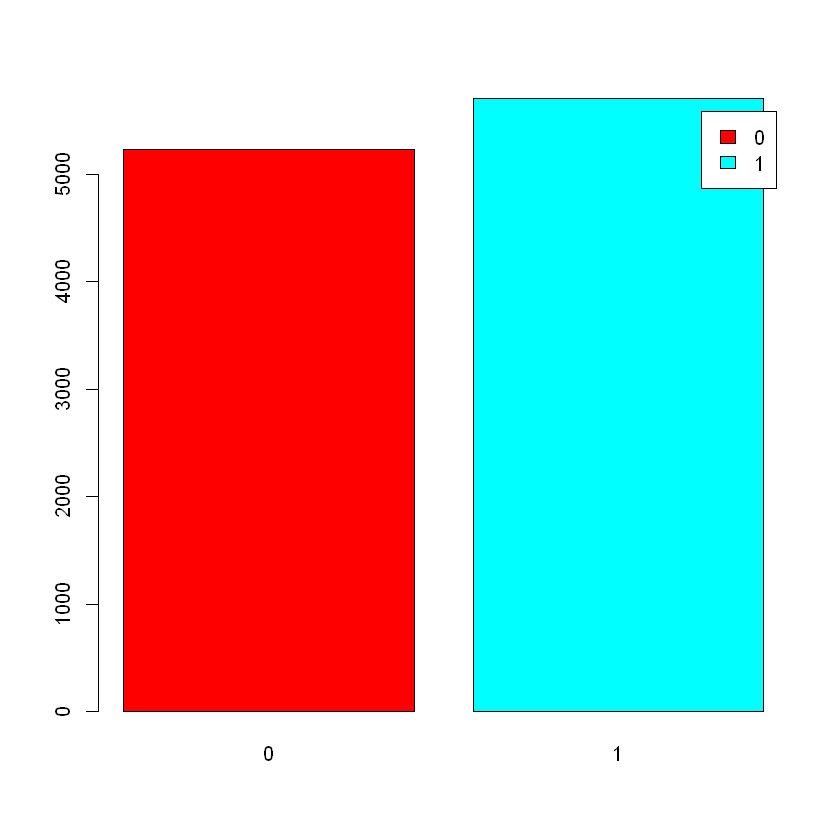

In [5]:
(tbl<-table(df$Label))
barplot(tbl,beside=T,legend=T,col=rainbow(2))
# 0종합평가점수 평균 미만 5230, 평균이상 5705
#0:1=5230:5230 으로 1:1로 언더샘플링

In [6]:
library(ROSE)
df_samp<-ovun.sample(Label ~ . , data=df, seed=1, method='under',
                    N=5230*2)$data
(tbl<-table(df_samp$Label)) #언더샘플링

Warning message:
"package 'ROSE' was built under R version 3.6.2"Loaded ROSE 0.0-3




   0    1 
5230 5230 

In [7]:
library(caret)
set.seed(123) #학습용:검증용 7:3으로 구분
idx_train<-createDataPartition(y=df_samp$Label,p=0.7,list=F)
train<-df_samp[idx_train,] #학습용
X_train<-train[,-40]
y_train<-train[,40]
test<-df_samp[-idx_train,] #검증용
X_test<-test[,-40]
y_test<-test[,40]

Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.2"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.2"

In [11]:
library(party)
#가지치기, 최대 단계 설정
a<-ctree_control(maxdepth=3)

model<-ctree(Label ~. , data=train, control=a) #의사결정 나무 모형
model


	 Conditional inference tree with 7 terminal nodes

Response:  Label 
Inputs:  age, height, weight, potential, right_foot, left_foot, crossing, finishing, heading_accuracy, short_passing, volleys, dribbling, curve, free_kick_accuracy, long_passing, ball_control, acceleration, sprint_speed, agility, reactions, balance, shot_power, jumping, stamina, strength, long_shots, aggression, interceptions, positioning, vision, penalties, marking, standing_tackle, sliding_tackle, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes 
Number of observations:  7322 

1) potential <= 72; criterion = 1, statistic = 3015.41
  2) potential <= 68; criterion = 1, statistic = 414.3
    3)*  weights = 1632 
  2) potential > 68
    4) reactions <= 66; criterion = 1, statistic = 306.41
      5)*  weights = 889 
    4) reactions > 66
      6)*  weights = 509 
1) potential > 72
  7) reactions <= 66; criterion = 1, statistic = 1540.695
    8) strength <= 69; criterion = 1, statistic = 97.151
      9)*

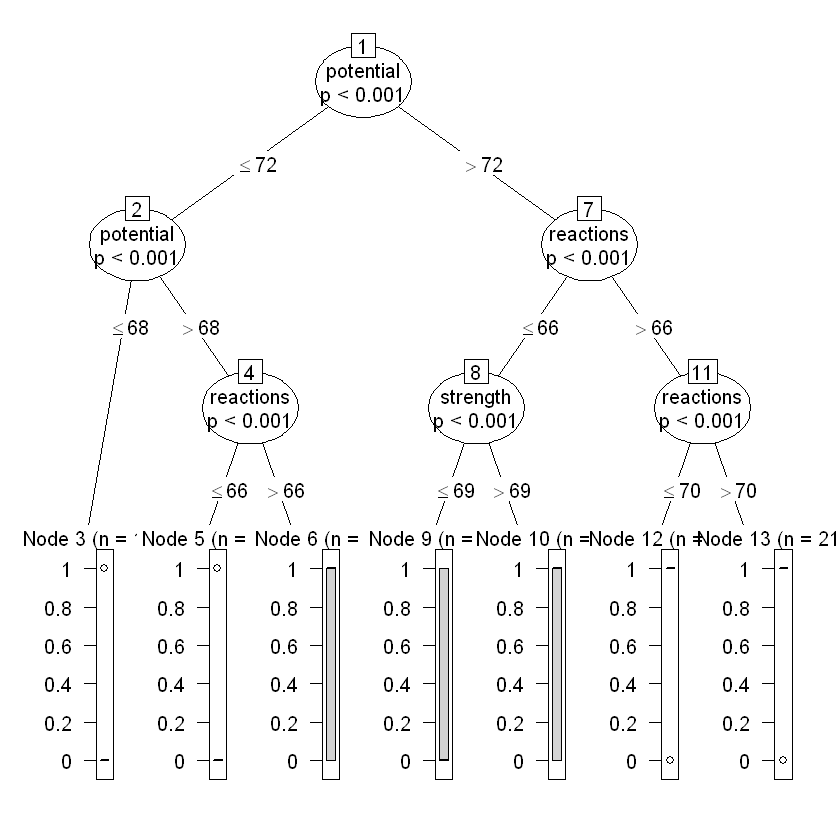

In [12]:
plot(model) #트리 그래프

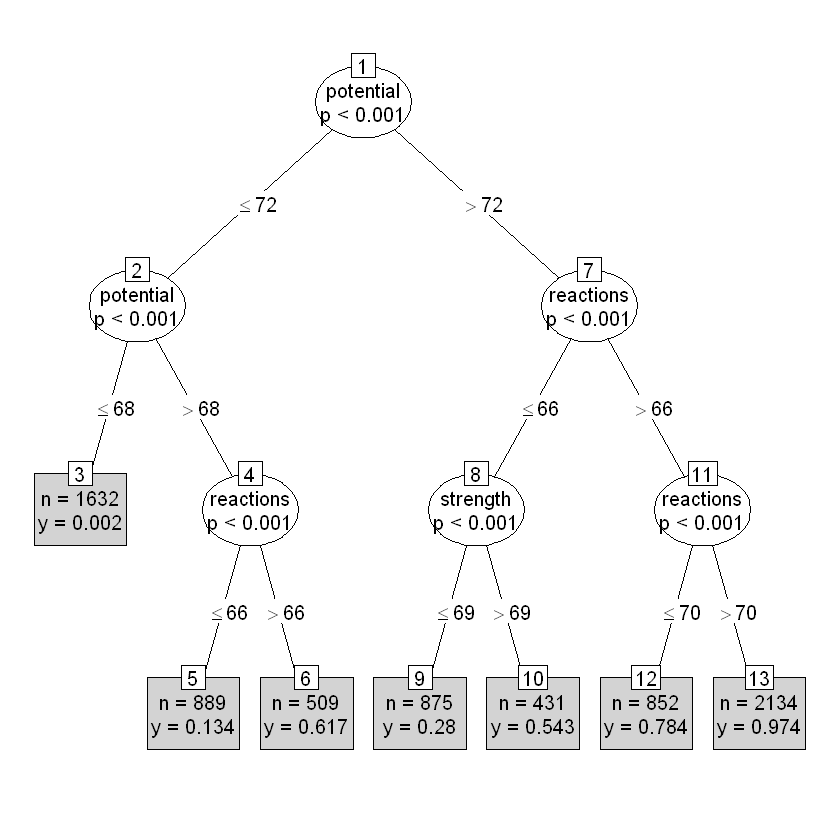

In [13]:
plot(model, type='simple')

In [14]:
#학습용 데이터셋의 예측정확도
pred<-predict(model,newdata=X_train,type='response')
result<-round(pred)
mean(y_train==result) #93.9% 가지치기 후 정확도 86.3%
table(y_train,result)

[1] 0.8635619

       result
y_train    0    1
      0 3029  632
      1  367 3294

In [15]:
#검증용 데이터셋의 예측정확도
pred<-predict(model,newdata=X_test,type='response')
result<-round(pred)
mean(y_test==result) #91.9% 가지치기 후 85.7
table(y_test,result)

[1] 0.8575526

      result
y_test    0    1
     0 1292  277
     1  170 1399

In [16]:
#랜덤포레스트 모형
library(randomForest)
set.seed(1)
model<-randomForest(Label ~. , data=train,
                   mtry=floor(sqrt(ncol(train))),ntree=10,
                   importance=T)
model

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Call:
 randomForest(formula = Label ~ ., data = train, mtry = floor(sqrt(ncol(train))),      ntree = 10, importance = T) 
               Type of random forest: regression
                     Number of trees: 10
No. of variables tried at each split: 6

          Mean of squared residuals: 0.0347729
                    % Var explained: 86.09

In [17]:
#학습용 데이터셋의 예측정확도
pred<-predict(model,newdata=X_train,type='response')
result<-round(pred)
mean(y_train==result) #99.6%
table(y_train,result)

[1] 0.9960393

       result
y_train    0    1
      0 3645   16
      1   13 3648

In [18]:
#검증용 데이터셋의 예측정확도
pred<-predict(model,newdata=X_test,type='response')
result<-round(pred)
mean(y_test==result) #97.3%
table(y_test,result)

[1] 0.9732314

      result
y_test    0    1
     0 1528   41
     1   43 1526

In [19]:
importance(model) #특성의 정확도, 중요도

,%IncMSE,IncNodePurity
age,0.6990108,4.1797943
height,-0.2238588,4.1264305
weight,0.9480836,6.4309798
potential,6.5529139,139.9053659
right_foot,1.5705928,0.9076732
left_foot,2.5465248,1.4779675
crossing,4.4807173,35.5144978
finishing,3.8331142,36.6536319
heading_accuracy,4.3549849,41.8875199
short_passing,7.0637458,46.2918312


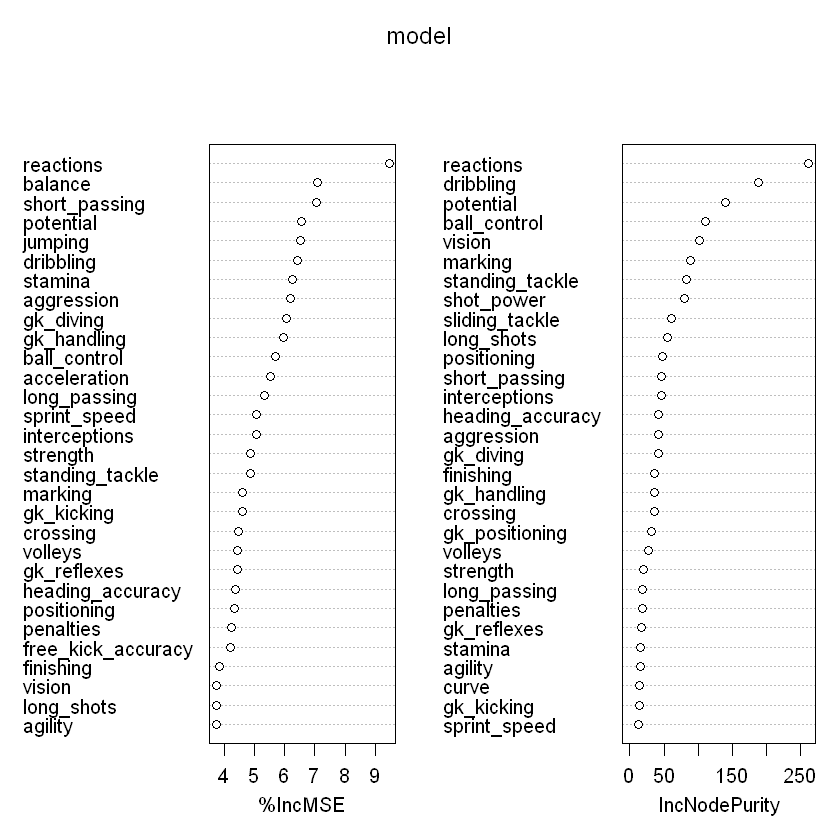

In [20]:
varImpPlot(model)